In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from dataclasses import dataclass
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests
import cv2
from itertools import combinations
from sklearn.model_selection import train_test_split
import random
from scipy.ndimage import label

/home/ubuntu/cali-recod/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Imports for embedding models (loaded on-demand to save GPU memory)
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoProcessor
import open_clip

In [3]:
# config variables
forged_dir = "data/train_images/forged"
authentic_dir = "data/train_images/authentic"
mask_dir = "data/train_masks"
device = "cuda" if torch.cuda.is_available() else "cpu"

training_size = .8

In [4]:
# visualization functions
def display_image_with_mask(
    image: Image.Image,
    mask: np.ndarray,
    opacity: float = 0.5,
    color: str = "red",
    only_outline: bool = True,
    separate_images: bool = False,
    show_labels: bool = False
):
    """
    Display an image with a mask overlay.

    Args:
        image (PIL.Image.Image): The image to display.
        mask (np.ndarray): Binary mask(s) to overlay on the image.
        opacity (float): The opacity of the mask overlay.
        color (str): The color of the mask overlay.
        only_outline (bool): Whether to only display the outline of the mask.
        separate_images (bool): If True, display each mask on a separate image.
                                If False, display all masks on one image.
        show_labels (bool): If True, display object index numbers at centroids.
    """
    img_array = np.array(image)
    color_rgb = matplotlib.colors.to_rgb(color)

    if not separate_images:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img_array)

    for i in range(mask.shape[0]):
        if separate_images:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(img_array)

        mask_i = mask[i].astype(np.uint8)

        if only_outline:
            contours, _ = cv2.findContours(mask_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour = contour.squeeze()
                if len(contour.shape) == 2:
                    ax.plot(contour[:, 0], contour[:, 1], color=color, linewidth=2)
        else:
            overlay = np.zeros((*mask_i.shape, 4))
            overlay[mask_i == 1] = [*color_rgb, opacity]
            ax.imshow(overlay)

        if show_labels:
            ys, xs = np.where(mask_i)
            if len(xs) > 0:
                cx, cy = xs.mean(), ys.mean()
                ax.text(cx, cy, str(i), fontsize=10, color='white', fontweight='bold',
                        ha='center', va='center', bbox=dict(boxstyle='round,pad=0.2', 
                        facecolor='black', alpha=0.7))

        if separate_images:
            ax.axis('off')
            plt.tight_layout()
            plt.show()

    if not separate_images:
        ax.axis('off')
        plt.tight_layout()
        plt.show()

In [5]:
@dataclass
class Sam3Results:
    scores: torch.Tensor
    boxes: torch.Tensor
    masks: torch.Tensor

@dataclass
class Sample:
    image: Image.Image
    ground_truth_mask: np.ndarray
    sam3_results: Sam3Results = None

In [6]:
forged_image_paths = sorted([f for f in os.listdir(forged_dir)])
forged_mask_paths = sorted([f for f in os.listdir(mask_dir)])
authentic_image_paths = sorted([f for f in os.listdir(authentic_dir)])

forged_images = [Image.open(os.path.join(forged_dir, f)) for f in forged_image_paths]
forged_masks = [np.load(os.path.join(mask_dir, f)) for f in forged_mask_paths]
authentic_images = [Image.open(os.path.join(authentic_dir, f)) for f in authentic_image_paths]

forged_samples = list(zip(forged_images, forged_masks))
authentic_samples = list(zip(authentic_images, [None for _ in authentic_images]))
all_samples = forged_samples + authentic_samples
all_samples = [Sample(image, mask) for image, mask in all_samples]

# shuffle the samples
random.Random(42).shuffle(all_samples)

print("forged set: ", len(forged_samples))
print("authentic set: ", len(authentic_samples))

train_samples, test_samples = train_test_split(all_samples, test_size=1-training_size, random_state=42)

forged set:  2751
authentic set:  2377


In [25]:
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1143.12it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


In [26]:
def get_sam3_results(
    model: Sam3Model,
    processor: Sam3Processor,
    samples: list[Sample],
    batch_size: int = 1
) -> list[Sample]:

    new_samples = []

    for i in range(0, len(samples), batch_size):
        batch = samples[i:i+batch_size]
        images = [sample.image for sample in batch]
        masks = [sample.ground_truth_mask for sample in batch]

        inputs = processor(images=images, text=["distinct object"] * len(images), return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            results_batch = processor.post_process_instance_segmentation(
                outputs,
                threshold=0.2,
                mask_threshold=0.5,
                target_sizes=inputs.get("original_sizes").tolist()
            )
            

        for img, mask, results in zip(images, masks, results_batch):
            new_samples.append(Sample(
                image=img,
                ground_truth_mask=mask,
                sam3_results=Sam3Results(**results)
            ))

    return new_samples

def get_masked_crop(image, mask):
    """Extract bounding box crop of masked region, filling outside with inverse of average color"""
    mask_np = mask.cpu().numpy()
    ys, xs = np.where(mask_np)
    if len(xs) == 0:
        return None
    
    img_array = np.array(image.convert("RGB"))
    
    # Calculate average color of masked region, then invert it
    avg_color = img_array[mask_np == 1].mean(axis=0)
    inv_color = 255 - avg_color
    
    # Fill outside mask with inverse color
    masked_img = img_array.copy()
    masked_img[mask_np == 0] = inv_color
    
    # Crop to bounding box
    crop = Image.fromarray(masked_img[ys.min():ys.max()+1, xs.min():xs.max()+1].astype(np.uint8))
    return crop

In [27]:
train_samples_with_sam3 = get_sam3_results(model, processor, train_samples[18:19])

# Free SAM3 from GPU
del model
torch.cuda.empty_cache()

In [28]:
num = 0
sample_x = train_samples_with_sam3[num]

print(f"Found {len(sample_x.sam3_results.masks)} objects")
sample_x.ground_truth_mask.shape

Found 30 objects


(3, 256, 256)

In [ ]:
def get_gt_indices_in_sam3_results(ground_truth_mask: np.ndarray, sam3_results: Sam3Results) -> list[list[int]]:
    
    results = []

    for i in range(ground_truth_mask.shape[0]):
        channel_results = []
        gt_mask = ground_truth_mask[i]
        # split into distinct masks per object
        labeled_mask, num_objects = label(gt_mask)
        for obj_id in range(1, num_objects + 1):
            object_mask = (labeled_mask == obj_id).astype(gt_mask.dtype)
            # here we want to loop over the sam3_results.masks and find the index with the highest IoU
            max_iou = 0
            max_iou_index = -1
            for j in range(sam3_results.masks.shape[0]):
                sam3_mask = sam3_results.masks[j].cpu().numpy()
                iou = np.sum(object_mask & sam3_mask) / np.sum(object_mask | sam3_mask)
                if iou > max_iou:
                    max_iou = iou
                    max_iou_index = j
            channel_results.append(max_iou_index)
        results.append(channel_results)

    return results


x = get_gt_indices_in_sam3_results(sample_x.ground_truth_mask, sample_x.sam3_results)


In [30]:
x

# 18, 13/4
# 9, 19/?
# 16, 8


[[25, 18], [13, 9], [23, 12]]

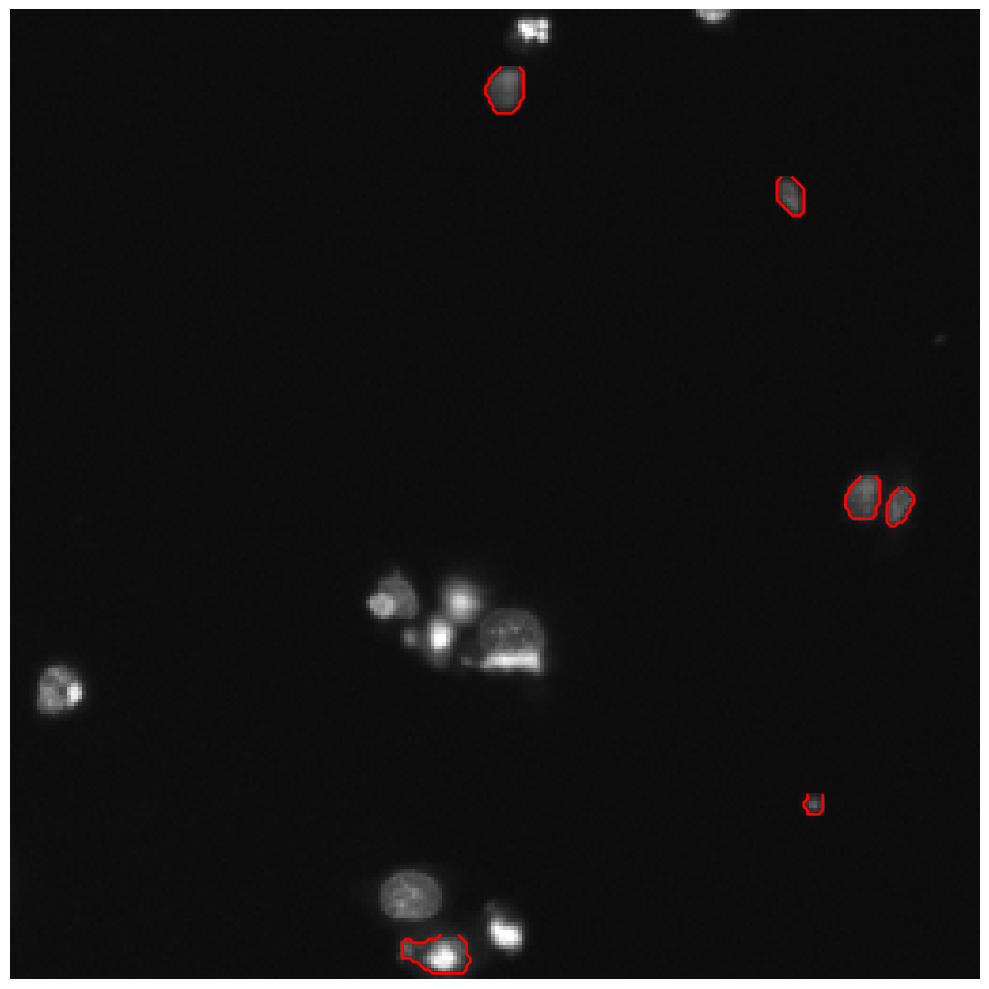

In [31]:

sam3_masks = sample_x.sam3_results.masks.cpu().numpy()

# Flatten indices and grab masks
flat_indices = [idx for sublist in x for idx in sublist]
our_masks = sam3_masks[flat_indices]

display_image_with_mask(
    sample_x.image,
    our_masks,
    # opacity=0.0,
    # only_outline=False
)

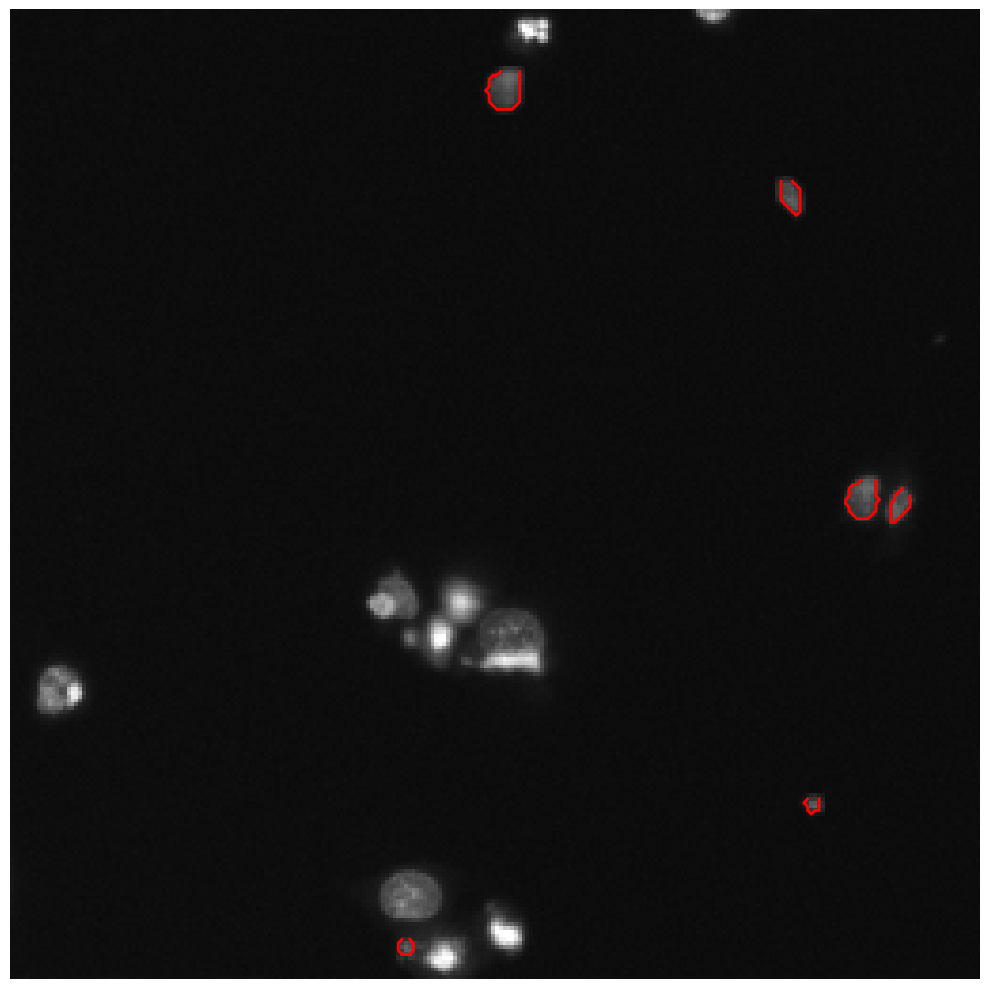

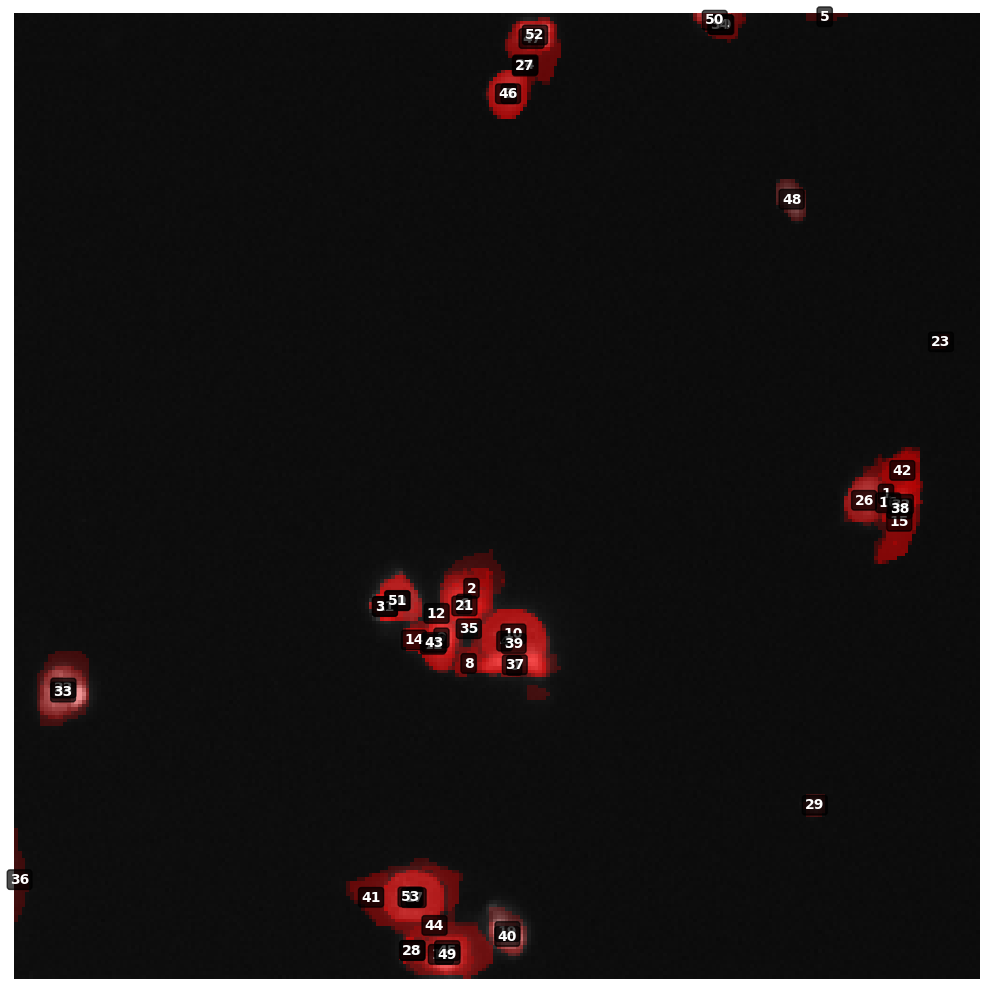

In [24]:
display_image_with_mask(
    sample_x.image,
    sample_x.ground_truth_mask,
    # opacity=0.0,
    # only_outline=False
)
display_image_with_mask(
    sample_x.image,
    sample_x.sam3_results.masks.cpu().numpy(),
    show_labels=True,
    opacity=0.2,
    only_outline=False

)

In [ ]:
def add_hu_moments(samples: list[Sample]):
    for sample in samples:
        masks = sample.sam3_results["masks"].cpu().numpy().astype(np.uint8)
        hu_moments_list = []
        for i in range(masks.shape[0]):
            mask_np = masks[i]  # Get single 2D mask
            moments = cv2.moments(mask_np)
            hu = cv2.HuMoments(moments).flatten()

            # Sign-preserving log transformation
            hu_log = np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
            hu_moments_list.append(np.round(hu_log, 4))
        sample.hu_moments = np.array(hu_moments_list)
    return samples

train_samples_with_hu_moments = add_hu_moments(train_samples_with_sam3)

def find_closest_by_hu_moments(hu_moments: np.ndarray, obj_idx: int, k: int = 10) -> list[tuple[int, float]]:
    """Find k closest objects to obj_idx by Hu moment distance. Returns [(idx, distance), ...]"""
    distances = [(i, np.linalg.norm(hu_moments[obj_idx] - hu_moments[i])) 
                 for i in range(len(hu_moments)) if i != obj_idx]
    distances.sort(key=lambda x: x[1])
    return distances[:k]

def find_closest_by_embeddings(embeddings: list, obj_idx: int, k: int = 10) -> list[tuple[int, float]]:
    """Find k closest objects to obj_idx by cosine distance. Returns [(idx, distance), ...]"""
    if embeddings[obj_idx] is None:
        return []
    distances = []
    for i in range(len(embeddings)):
        if i == obj_idx or embeddings[i] is None:
            continue
        sim = np.dot(embeddings[obj_idx], embeddings[i]) / (np.linalg.norm(embeddings[obj_idx]) * np.linalg.norm(embeddings[i]))
        distances.append((i, 1 - sim))
    distances.sort(key=lambda x: x[1])
    return distances[:k]

sample_x = train_samples_with_hu_moments[num]

In [ ]:
query_obj = 11

In [ ]:
# Find 10 closest objects to object 0 by Hu moments
closest = find_closest_by_hu_moments(sample_x.hu_moments, query_obj)
print(f"Hu moments - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

# Display query object and its closest matches
masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))

In [ ]:
# Load CLIP Base
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Get CLIP embeddings for each object
clip_embeddings = []
for mask in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, mask)
    if crop is None:
        clip_embeddings.append(None)
        continue
    inputs = clip_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
    clip_embeddings.append(emb[0].cpu().numpy())

# Free CLIP Base
del clip_model, clip_processor
torch.cuda.empty_cache()

In [ ]:
# Find 10 closest objects by CLIP
closest = find_closest_by_embeddings(clip_embeddings, query_obj)
print(f"CLIP - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))

In [ ]:
# Load CLIP Large
clip_large_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_large_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Get CLIP Large embeddings for each object
clip_large_embeddings = []
for mask in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, mask)
    if crop is None:
        clip_large_embeddings.append(None)
        continue
    inputs = clip_large_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = clip_large_model.get_image_features(**inputs)
    clip_large_embeddings.append(emb[0].cpu().numpy())

# Free CLIP Large
del clip_large_model, clip_large_processor
torch.cuda.empty_cache()

# Find 10 closest objects by CLIP Large
closest = find_closest_by_embeddings(clip_large_embeddings, query_obj)
print(f"CLIP Large - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))


In [ ]:
# Load DINOv2
dino_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
dino_model = AutoModel.from_pretrained("facebook/dinov2-base").to(device)

# Get DINOv2 embeddings for each object
dino_embeddings = []
for mask in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, mask)
    if crop is None:
        dino_embeddings.append(None)
        continue
    inputs = dino_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = dino_model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1)[0]  # Pool over patches
    dino_embeddings.append(emb.cpu().numpy())

# Free DINOv2
del dino_model, dino_processor
torch.cuda.empty_cache()

# Find 10 closest objects by DINOv2
closest = find_closest_by_embeddings(dino_embeddings, query_obj)
print(f"DINOv2 - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))


In [ ]:
# Load SigLIP
siglip_processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
siglip_model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384").to(device)

# Get SigLIP embeddings for each object
siglip_embeddings = []
for mask in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, mask)
    if crop is None:
        siglip_embeddings.append(None)
        continue
    inputs = siglip_processor(images=crop, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = siglip_model.get_image_features(**inputs)
    siglip_embeddings.append(outputs[0].cpu().numpy())

# Free SigLIP
del siglip_model, siglip_processor
torch.cuda.empty_cache()

# Find 10 closest objects by SigLIP
closest = find_closest_by_embeddings(siglip_embeddings, query_obj)
print(f"SigLIP - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))


In [ ]:
# Load EVA-CLIP
eva_model, _, eva_preprocess = open_clip.create_model_and_transforms('EVA02-B-16', pretrained='merged2b_s8b_b131k')
eva_model = eva_model.to(device)

# Get EVA-CLIP embeddings for each object
eva_embeddings = []
for mask in sample_x.sam3_results["masks"]:
    crop = get_masked_crop(sample_x.image, mask)
    if crop is None:
        eva_embeddings.append(None)
        continue
    img_tensor = eva_preprocess(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = eva_model.encode_image(img_tensor)
    eva_embeddings.append(emb[0].cpu().numpy())

# Free EVA-CLIP
del eva_model, eva_preprocess
torch.cuda.empty_cache()

# Find 10 closest objects by EVA-CLIP
closest = find_closest_by_embeddings(eva_embeddings, query_obj)
print(f"EVA-CLIP - 10 closest to object {query_obj}:")
for idx, dist in closest:
    print(f"  {idx}: {dist:.4f}")

masks = sample_x.sam3_results["masks"].cpu().numpy()
display_image_with_mask(sample_x.image, np.array([masks[query_obj]] + [masks[idx] for idx, _ in closest]))
